<a href="https://colab.research.google.com/github/evergreenllc2020/bertsearch/blob/master/Fine_Tune_BERT_for_Text_Classification_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

In this [project](https://www.coursera.org/projects/fine-tune-bert-tensorflow/), you will learn how to fine-tune a BERT model for text classification using TensorFlow and TF-Hub.

The pretrained BERT model used in this project is [available](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2) on [TensorFlow Hub](https://tfhub.dev/).

### Learning Objectives

By the time you complete this project, you will be able to:

- Build TensorFlow Input Pipelines for Text Data with the [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data) API
- Tokenize and Preprocess Text for BERT
- Fine-tune BERT for text classification with TensorFlow 2 and [TF Hub](https://tfhub.dev)

### Prerequisites

### Contents

## Task 2: Setup your TensorFlow and Colab Runtime.

### Check GPU Availability

Check if your Colab notebook is configured to use Graphical Processing Units (GPUs). If zero GPUs are available, check if the Colab notebook is configured to use GPUs (Menu > Runtime > Change Runtime Type).

![Hardware Accelerator Settings](https://drive.google.com/uc?id=1qrihuuMtvzXJHiRV8M7RngbxFYipXKQx)


In [1]:
!nvidia-smi

Wed Jan 27 03:18:52 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Install TensorFlow and TensorFlow Model Garden

In [2]:
import tensorflow as tf
print(tf.version.VERSION)

2.4.0


In [ ]:
!pip install -q tensorflow==2.3.0

In [3]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2310/2310), done.
remote: Total 2650 (delta 508), reused 1388 (delta 307), pack-reused 0
Receiving objects: 100% (2650/2650), 34.01 MiB | 31.92 MiB/s, done.
Resolving deltas: 100% (508/508), done.
Note: checking out '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>



In [4]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt
# you may have to restart the runtime afterwards

     |████████████████████████████████| 71kB 2.5MB/s 
     |████████████████████████████████| 215kB 7.6MB/s 
     |████████████████████████████████| 296kB 41.6MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 25.9MB 123kB/s 
     |████████████████████████████████| 174kB 45.6MB/s 
     |████████████████████████████████| 3.7MB 36.8MB/s 
     |████████████████████████████████| 706kB 38.4MB/s 
     |████████████████████████████████| 358kB 49.3MB/s 
     |████████████████████████████████| 1.2MB 34.1MB/s 
     |████████████████████████████████| 11.6MB 44.2MB/s 
     |████████████████████████████████| 37.6MB 64kB/s 
     |████████████████████████████████| 645kB 44.9MB/s 
     |████████████████████████████████| 2.2MB 35.0MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
     |████████████████████████████████| 81kB 8.3MB/s 
ERROR: pandas-gbq 0.13.3 has requirement google-cloud-b

## Restart the Runtime

**Note** 
After installing the required Python packages, you'll need to restart the Colab Runtime Engine (Menu > Runtime > Restart runtime...)

![Restart of the Colab Runtime Engine](https://drive.google.com/uc?id=1xnjAy2sxIymKhydkqb0RKzgVK9rh3teH)

## Task 3: Download and Import the Quora Insincere Questions Dataset

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

In [2]:
print("TF Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.experimental.list_physical_devices("GPU") else "NOT AVAILABLE")

TF Version:  2.4.0
Eager mode:  True
Hub version:  0.11.0
GPU is available


A downloadable copy of the [Quora Insincere Questions Classification data](https://www.kaggle.com/c/quora-insincere-questions-classification/data) can be found [https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip](https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip). Decompress and read the data into a pandas DataFrame.

In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression='zip',low_memory=False)
df.shape

(1306122, 3)

In [4]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


<AxesSubplot:title={'center':'target distribution'}, ylabel='Frequency'>

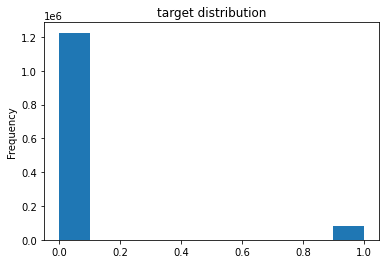

In [5]:
df.target.plot(kind='hist', title='target distribution')

In [6]:
insincere_df_10k = df[df.target==1]
insincere_df_10k  = insincere_df_10k.head(50000)
insincere_df_10k.head(20)

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1
115,000537213b01fd77b58a,Which races have the smallest penis?,1
119,00056d45a1ce63856fc6,Why do females find penises ugly?,1
127,0005de07b07a17046e27,How do I marry an American woman for a Green C...,1
144,00068875d7c82a5bcf88,Why do Europeans say they're the superior race...,1
156,0006ffd99a6599ff35b3,Did Julius Caesar bring a tyrannosaurus rex on...,1
167,00075f7061837807c69f,In what manner has Republican backing of 'stat...,1


In [7]:
sincere_df_10k = df[df.target==0]
sincere_df_10k  = sincere_df_10k.head(50000)
sincere_df_10k.head(20)


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
5,00004f9a462a357c33be,"Is Gaza slowly becoming Auschwitz, Dachau or T...",0
6,00005059a06ee19e11ad,Why does Quora automatically ban conservative ...,0
7,0000559f875832745e2e,Is it crazy if I wash or wipe my groceries off...,0
8,00005bd3426b2d0c8305,"Is there such a thing as dressing moderately, ...",0
9,00006e6928c5df60eacb,Is it just me or have you ever been in this ph...,0


(100000, 3)

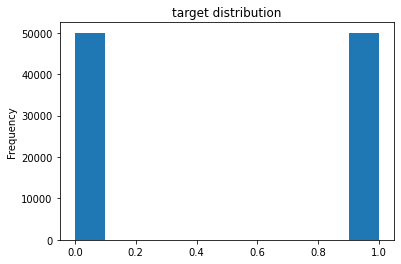

In [8]:
new_train_df = pd.concat([sincere_df_10k,insincere_df_10k])
new_train_df.shape
df=new_train_df
df.target.plot(kind='hist', title='target distribution')
df.shape

## Task 4: Create tf.data.Datasets for Training and Evaluation

In [9]:
#train_df, remaining = train_test_split(df, random_state=42, train_size=0.0075, stratify=df.target.values)
#valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.00075, stratify=remaining.target.values)
train_df, remaining = train_test_split(df, random_state=42, train_size=0.9, stratify=df.target.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.1, stratify=remaining.target.values)


train_df.shape, valid_df.shape

((90000, 3), (1000, 3))

In [10]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df['question_text'].values, train_df['target'].values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df['question_text'].values, valid_df['target'].values))
    
  for text, label in train_data.take(1):
    print(text)
    print(label)  

tf.Tensor(b'What are some inspirational quotes from the novel "The Adventures of Pinocchio" by Carlo Collodi?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


## Task 5: Download a Pre-trained BERT Model from TensorFlow Hub

In [11]:
"""
Each line of the dataset is composed of the review text and its label
- Data preprocessing consists of transforming text to BERT input features:
input_word_ids, input_mask, segment_ids
- In the process, tokenizing the text is done with the provided BERT model tokenizer
"""

 # Label categories
label_list = [0,1]


 # maximum length of (token) input sequences
max_seq_length = 128
train_batch_size = 32



# Get BERT layer and tokenizer:
# More details here: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2
bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)




In [12]:
tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?')

['hi', '##,', 'how', 'are', 'you', 'doing', '##?']

In [13]:
 tokenizer.convert_tokens_to_ids(tokenizer.wordpiece_tokenizer.tokenize('hi, how are you doing?'))

[7632, 29623, 2129, 2024, 2017, 2725, 29632]

## Task 6: Tokenize and Preprocess Text for BERT

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1-SpKFELnEvBMBqO7h3iypo8q9uUUo96P' />
    <p style="text-align: center;color:gray">Figure 2: BERT Tokenizer</p>
</div>

We'll need to transform our data into a format BERT understands. This involves two steps. First, we create InputExamples using `classifier_data_lib`'s constructor `InputExample` provided in the BERT library.

In [14]:
# This provides a function to convert row to input features and label

def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid=None,
                                             text_a = text.numpy(),
                                             text_b = None,
                                             label = label.numpy())
  feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

  
  

You want to use [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) to apply this function to each element of the dataset. [`Dataset.map`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) runs in graph mode.

- Graph tensors do not have a value.
- In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function). The [`tf.py_function`](https://www.tensorflow.org/api_docs/python/tf/py_function) will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

## Task 7: Wrap a Python Function into a TensorFlow op for Eager Execution

In [15]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text,label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([])
  x = {'input_words_ids' : input_ids,
       'input_mask': input_mask,
       'input_type_id': segment_ids
       }  
  return (x, label_id)
  

## Task 8: Create a TensorFlow Input Pipeline with `tf.data`

In [16]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .shuffle(1000)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  # valid
  valid_data = (valid_data.map(to_feature_map,
                               num_parallel_calls=tf.data.experimental.AUTOTUNE)
  .batch(32, drop_remainder=True)        
  .prefetch(tf.data.experimental.AUTOTUNE))

  
  

The resulting `tf.data.Datasets` return `(features, labels)` pairs, as expected by [`keras.Model.fit`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit):

In [17]:
# train data spec
train_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [18]:
# valid data spec
valid_data.element_spec

({'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_id': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_words_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

## Task 9: Add a Classification Head to the BERT Layer

<div align="center">
    <img width="512px" src='https://drive.google.com/uc?id=1fnJTeJs5HUpz7nix-F9E6EZdgUflqyEu' />
    <p style="text-align: center;color:gray">Figure 3: BERT Layer</p>
</div>

In [19]:
# Building the model
def create_model():
  input_words_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_words_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
  input_type_id = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_type_id")
  pooled_output, sequence_output = bert_layer([input_words_ids, input_mask, input_type_id])
  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(drop)
  model = tf.keras.Model(
           inputs = {
               'input_words_ids': input_words_ids,
               'input_mask': input_mask,
               'input_type_id': input_type_id          
           },
           outputs = output )
  return model

## Task 10: Fine-Tune BERT for Text Classification

In [20]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_words_ids (InputLayer)    [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_type_id (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_words_ids[0][0]            
                                                                 input_mask[0][0]             

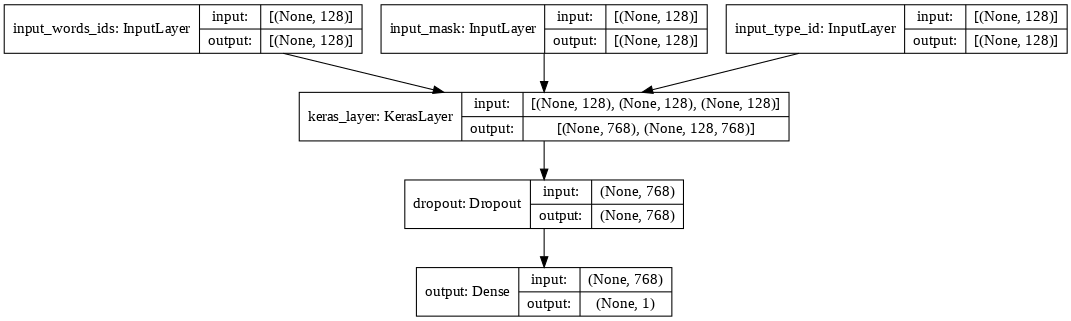

In [21]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi=76)

In [22]:
# Train model
epochs = 4
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=epochs,
                    verbose=1)

Epoch 1/4
2812/2812 [==============================] - 1333s 469ms/step - loss: 0.2947 - binary_accuracy: 0.8812 - val_loss: 0.2151 - val_binary_accuracy: 0.9214
Epoch 2/4
2812/2812 [==============================] - 1318s 468ms/step - loss: 0.1797 - binary_accuracy: 0.9349 - val_loss: 0.2305 - val_binary_accuracy: 0.9153
Epoch 3/4
2812/2812 [==============================] - 1318s 468ms/step - loss: 0.1046 - binary_accuracy: 0.9659 - val_loss: 0.2668 - val_binary_accuracy: 0.9143
Epoch 4/4
2812/2812 [==============================] - 1316s 468ms/step - loss: 0.0620 - binary_accuracy: 0.9814 - val_loss: 0.3169 - val_binary_accuracy: 0.9173


## Task 11: Evaluate the BERT Text Classification Model

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

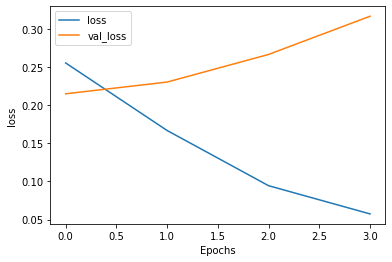

In [24]:
plot_graphs(history, 'loss')

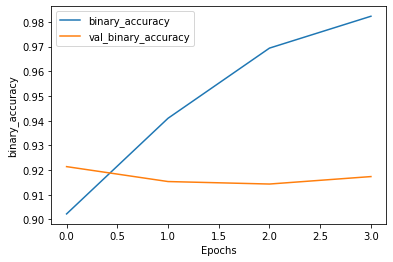

In [25]:
plot_graphs(history, 'binary_accuracy')

In [26]:
sample_example = ['Why is it that European food is so terrible?', 'Are you ashamed of being Indian?', 'What is best deep learning training course?']
test_data = tf.data.Dataset.from_tensor_slices((sample_example, [1]*len(sample_example)))
test_data = test_data.map(to_feature_map).batch(1)
preds = model.predict(test_data)
threshold = 0.5
['Insincere' if pred >= threshold else 'Sincere' for pred in preds]



['Insincere', 'Insincere', 'Sincere']